In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import sys
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
import tensorflow.keras as keras


In [2]:
IMAGE_SIZE = [224, 224]
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg.layers:
  layer.trainable = False
x = Flatten()(vgg.output)


In [3]:
train_path = "train_images/"
test_path = "test_images/"
batch_train = 25

# train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
# test_datagen = ImageDataGenerator(rescale = 1./255)

# training_set = train_datagen.flow_from_directory(
#     train_path, target_size = (224, 224), batch_size = 64, class_mode = 'categorical')
# test_set = test_datagen.flow_from_directory(test_path,
#                                             target_size = (224, 224),
#                                             batch_size = 32,
#                                             class_mode = 'categorical')

def generators(shape, preprocessing): 
    '''Create the training and validation datasets for 
    a given image shape.
    '''
    imgdatagen = ImageDataGenerator(
        preprocessing_function = preprocessing,
        horizontal_flip = True, 
        validation_split = 0.1,
        shear_range = 0.2, zoom_range = 0.2,
        rescale = 1./255
    )

    height, width = shape

    train_dataset = imgdatagen.flow_from_directory(
        "train_images/",
        target_size = (height, width), 
        batch_size = batch_train,
        subset = 'training', 
        class_mode = 'categorical'
    )

    val_dataset = imgdatagen.flow_from_directory(
        "train_images/",
        target_size = (height, width), 
        batch_size = batch_train,
        subset = 'validation'
    )
    return train_dataset, val_dataset

train_dataset, val_dataset = generators(IMAGE_SIZE, preprocessing=preprocess_input)



Found 48760 images belonging to 15 classes.
Found 5412 images belonging to 15 classes.


In [4]:
# Visualize the model
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# flatten the output of the convolutional part: 
x = keras.layers.Flatten()(vgg.output)
# three hidden layers
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)
x = keras.layers.Dense(100, activation='relu')(x)

predictions = keras.layers.Dense(15, activation='softmax')(x)

# creating the full model:
full_model = keras.models.Model(inputs=vgg.input, outputs=predictions)
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(learning_rate=0.001),
                  metrics=['acc'])
history = full_model.fit(
    train_dataset, 
    validation_data = val_dataset,
    workers=10,
    epochs=3,
    use_multiprocessing = False
)

Epoch 1/3
1951/1951 [==============================] - 9987s 5s/step - loss: 1.8598 - acc: 0.4612 - val_loss: 1.8028 - val_acc: 0.4671
Epoch 2/3
1951/1951 [==============================] - 9844s 5s/step - loss: 1.8076 - acc: 0.4664 - val_loss: 1.8306 - val_acc: 0.4488
Epoch 3/3
1951/1951 [==============================] - 10756s 6s/step - loss: 1.7916 - acc: 0.4675 - val_loss: 1.8061 - val_acc: 0.4647


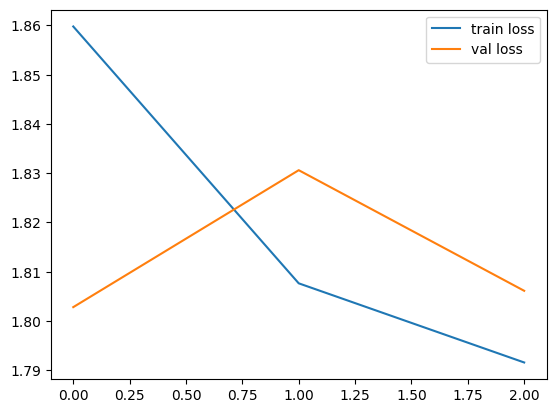

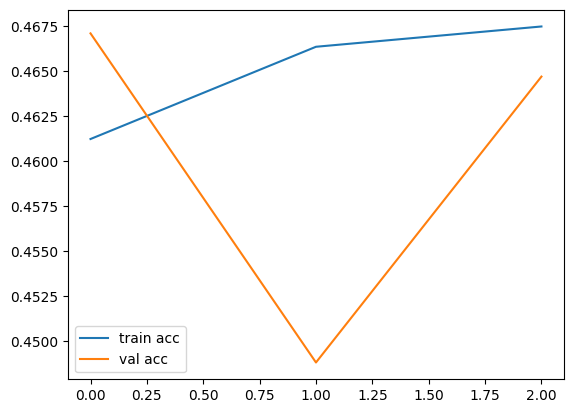

In [8]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
 
 # accuracies
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()
plt.show()

In [ ]:
# Save the VGG19 model as part of the TensorFlow graph
tf.saved_model.save(
        vgg,
    'graphs/vgg19_model',  # Replace 'path_to_save_model' with your desired path
)

In [ ]:
def preprocess(img, crop=True, resize=True, dsize=(224, 224)):
    if img.dtype == np.uint8:
        img = img / 255.0

    if crop:
        short_edge = min(img.shape[:2])
        yy = int((img.shape[0] - short_edge) / 2)
        xx = int((img.shape[1] - short_edge) / 2)
        crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    else:
        crop_img = img

    if resize:
        norm_img = imresize(crop_img, dsize, preserve_range=True)
    else:
        norm_img = crop_img

    return (norm_img).astype(np.float32)

def deprocess(img):
    return np.clip(img * 255, 0, 255).astype(np.uint8)

In [ ]:
# Create a new TensorFlow graph
g = tf.Graph()

# Define the function to load the VGG model into the graph
def load_vgg_model(graph):
    with g.as_default():
        sess = tf.compat.v1.keras.backend.get_session()
        graph_def = sess.graph.as_graph_def()
        # Import the graph definition into the provided graph
        tf.import_graph_def(graph_def, name='vgg19')
         # Get the input tensor of the VGG model
        input_tensor = g.get_tensor_by_name('input_1:0')  # Change 'input_1:0' to the correct input tensor name
        
        return vgg, input_tensor

# Load the VGG model into the graph 'g'
with g.as_default():
    vgg_model_loaded, input_tensor = load_vgg_model(g)
    
input_tensor

In [ ]:
def get_content_feature(img_4d):
# gets the content features from maxpool5 layer of vgg16 and feeds in data img_4d via placeholder x1.

    with tf.Session(graph=g1) as sess, g1.device('/gpu:0'):


            content_layer = 'vgg/pool5:0'
            content_features= g1.get_tensor_by_name(content_layer).eval(
                    session=sess,
                    feed_dict={x1: img_4d
                    })

            # train_new.append(content_features)
            print(content_features.shape)
            return content_features


In [ ]:
TRAIN_IMG_CODE_FOLDER = "train_img_codes/"
TEST_IMG_CODE_FOLDER = "test_img_codes/"
os.mkdir(TRAIN_IMG_CODE_FOLDER)
os.mkdir(TEST_IMG_CODE_FOLDER)


In [ ]:
training_folder_len = len(os.listdir('train_images/'))
numb_train_img = (training_folder_len - (training_folder_len%batch))+1
numb_train_img

In [ ]:
os.listdir('train_images/')

In [ ]:
for j in range(0,numb_train_img,batch):             #Process Training images in batches of 20 and feed them in content_features tensor and save the result in a wb pickle file  inside Training image code folder
    img=[]
    start_time = time.time()
    if j==numb_train_img-1:
        m = j+batch-training_folder_len
        print(m)

    for i in range(j+0,j+20-m):
        og = plt.imread("train_images"+"/"+str(i)+".png")
        og = preprocess(og)
        img.append(og)
    print("j=",j)
    x1 = g.get_tensor_by_name('vgg/images' + ':0')

    img_4d = np.array(img)
    print(img_4d.shape , "Image Shape")

In [ ]:
g